In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import os
import torchvision
import glob
import math
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets ,transforms 
from torch.utils.data import DataLoader ,random_split
from torchvision.io import read_image
import torch.nn.functional as F

torch.manual_seed(2021)
# Device configuration
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# read data sets without change png or jpg and without structure the data
data_dir = 'Train'
images_list = os.listdir(data_dir)
df =pd.DataFrame({'dirs':images_list})
df['label'] = df['dirs'].str.replace('_\d+.\w{3}',"",regex= True)

#data set class
class sport_dataset(datasets.DatasetFolder):  
  def __init__(self, root,df ,transform=None, target_transform=None):
    self.class_to_idx= { 
          'Basketball': 0, 'Football':1,
          'Rowing':2,'Swimming':3,
          'Tennis':4,'Yoga':5}
    mask = df["dirs"].str.lower().str.contains('.[p|j][p|n]g') 
    df = df[mask]
    df['label'] = df['label'].map(self.class_to_idx)
    
    self.dir = root if root[-1] == '/' else root+'/'
    self.image_labels = df['label'].tolist()
    self.images = df['dirs'].tolist()
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.image_labels)

  def __getitem__(self, idx):
    img_path =  self.dir  + self.images[idx]
    image = Image.open(img_path)
    label = self.image_labels[idx]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

class sport_dataset_test(datasets.DatasetFolder): 
  def __init__(self, root ,transform=None, target_transform=None):
    self.dir = root if root[-1] == '/' else root+'/'
    df= pd.DataFrame({'dirs':os.listdir(root)})
    mask = df["dirs"].str.lower().str.contains('.[p|j][p|n]g') 
    df = df[mask]
    self.images = df["dirs"].to_list()
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
        
    img_path =  self.dir  + self.images[idx]
    image = Image.open(img_path)
    if self.transform:
        image = self.transform(image)
    return image, self.images[idx]

FileNotFoundError: ignored

In [ ]:
num_classes = 6
num_epochs = 50
BATCH_SIZE = 16


In [ ]:
data_dir = 'Train'
test_dir = 'Test/'
split_size = 0.2
train_df, val_df = train_test_split(df, test_size=split_size, shuffle=True,stratify=df[['label']])

In [ ]:
vc = train_df.label.value_counts()
vct=vc.max() - vc
for clas , value in vct.to_dict().items():
    smaple_df = train_df.loc[train_df['label']==clas ,:]
    if value > 0:
        train_df = train_df.append(smaple_df.sample(value,replace= True,random_state =49), ignore_index=True)
train_df['label'].value_counts()

Swimming      366
Basketball    366
Yoga          366
Tennis        366
Football      366
Rowing        366
Name: label, dtype: int64

In [ ]:
tranform_train = transforms.Compose([#transforms.RandomVerticalFlip(p=0.2) ,
                                     #transforms.RandomHorizontalFlip(p=0.2), 
                                     #transforms.RandomPerspective(distortion_scale=0.3,p=0.2),
                                     #transforms.RandomRotation(degrees=45,),
                                     transforms.Resize((240,240)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

tranform_test = transforms.Compose([transforms.Resize((240,240)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, train_df  ,transform=tranform_train)
val = sport_dataset(data_dir, val_df ,transform=tranform_test)
test = sport_dataset_test(test_dir, transform=tranform_test)

# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True)
valid_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test, batch_size=1,  shuffle=False ,num_workers=0)
# print train test val sizes
print(train.class_to_idx)
print(f'''
Train data size : {len(train)}  
Val data size   : {len(val)} 
Test data size  : {len(test)}
''')

{'Basketball': 0, 'Football': 1, 'Rowing': 2, 'Swimming': 3, 'Tennis': 4, 'Yoga': 5}

Train data size : 2196  
Val data size   : 337 
Test data size  : 688



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([16, 3, 240, 240])


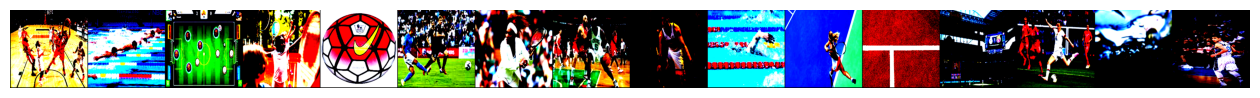

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Residual Block

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


# resnet

In [ ]:



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



# Setting Hyperparameters

In [ ]:
model =  Xception(num_classes=1000)
st = torch.load('xception.pth.tar')
model.load_state_dict(st)
model.to(device)
print('state_dict loaded')

state_dict loaded


In [ ]:
learning_rate = 5e-4
# Loss and optimizer
weights =  torch.tensor([1,1.15,1.15,1.1,1.5,1]).to(device).float()
criterion = nn.CrossEntropyLoss( )
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay = 0.0001, betas=(0.98,0.999))  
# Train the model
total_step = len(train_loader)

# Training:

In [ ]:
def feed_and_back(images , labels , back_prop = True):
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    # Backward and optimize
    if back_prop:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    del images, labels, outputs
    torch.cuda.empty_cache()
    gc.collect()
    return  loss , predicted , correct

In [ ]:
import gc
train_losses = []
val_losses = []
train_acc = []
val_acc = []
acc_old = 0 
num_epochs = 15
total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = True)
        correct += correct_batch
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)     
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in valid_loader:
            loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = False)
            correct += correct_batch
        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
            acc_old = val_acc[-1]
            torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), (100 * correct) / len(val)))
        



Epoch [1/15]: 
              T_Loss: 0.7462 , T_ACC: 38.2514% , validation:  Val_Loss: 1.9052 , Val_ACC: 68.2493%

Epoch [2/15]: 
              T_Loss: 0.5847 , T_ACC: 80.2823% , validation:  Val_Loss: 1.3074 , Val_ACC: 83.3828%

Epoch [3/15]: 
              T_Loss: 0.4823 , T_ACC: 87.0219% , validation:  Val_Loss: 1.4349 , Val_ACC: 88.7240%

Epoch [4/15]: 
              T_Loss: 0.2489 , T_ACC: 90.0273% , validation:  Val_Loss: 1.3774 , Val_ACC: 90.8012%

Epoch [5/15]: 
              T_Loss: 0.1216 , T_ACC: 91.4845% , validation:  Val_Loss: 1.2701 , Val_ACC: 91.9881%

Epoch [6/15]: 
              T_Loss: 0.3860 , T_ACC: 92.5774% , validation:  Val_Loss: 0.7698 , Val_ACC: 92.2849%

Epoch [7/15]: 
              T_Loss: 0.1965 , T_ACC: 93.1239% , validation:  Val_Loss: 0.4729 , Val_ACC: 93.7685%

Epoch [8/15]: 
              T_Loss: 0.3532 , T_ACC: 93.5337% , validation:  Val_Loss: 1.0405 , Val_ACC: 94.3620%

Epoch [9/15]: 
              T_Loss: 0.2546 , T_ACC: 94.2168% , validation:  Va

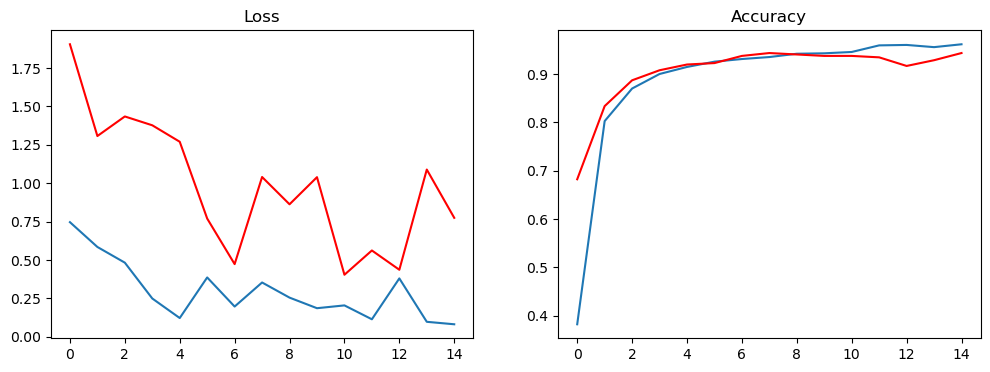

In [ ]:
fig2, ax = plt.subplots(1,2,  figsize=(12,4))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[0].plot(val_losses,'-r')
ax[1].plot(val_acc,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()
torch.save(model.state_dict(), 'best_model_last.pt')

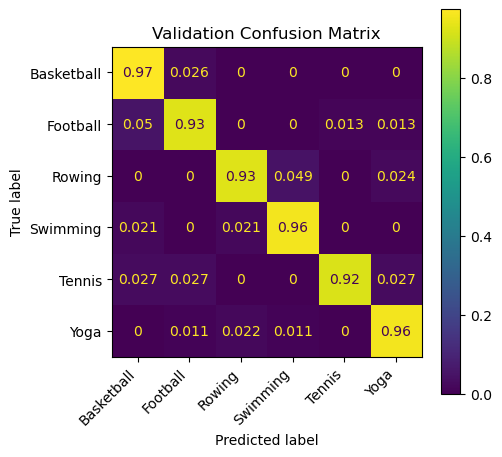

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

In [ ]:
#model.load_state_dict(torch.load('best_model_xc.pt'))
#model.eval()

In [ ]:
print(f"maxmium valadtion accuarcy : { max(val_acc):.4}% at Epoch {val_acc.index(max(val_acc))+1} ")

maxmium valadtion accuarcy : 0.9436% at Epoch 8 


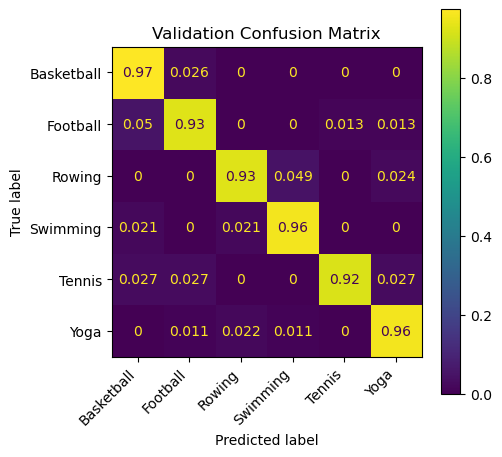

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

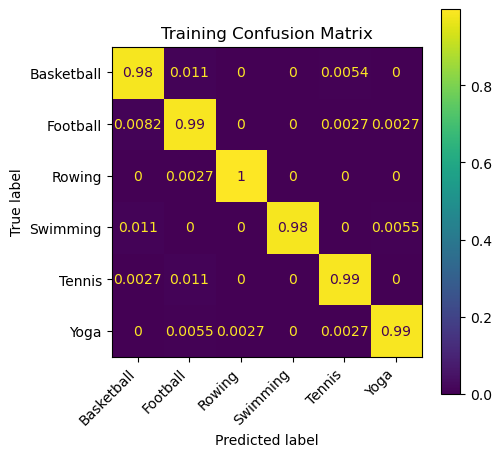

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Training Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

In [ ]:
learning_rate = 9e-5
num_epochs = 20
tranform_train = transforms.Compose([transforms.RandomVerticalFlip(p=0.2) ,
                                     transforms.RandomHorizontalFlip(p=0.4), 
                                     transforms.RandomPerspective(distortion_scale=0.5,p=0.5),
                                     transforms.RandomRotation(degrees=(-70, 70)),
                                     transforms.Resize((260,260)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

tranform_test = transforms.Compose([transforms.Resize((260,260)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

#prep the train, validation and test dataset
train = sport_dataset(data_dir, train_df  ,transform=tranform_train)
# train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last= True)

weights =  torch.tensor([1.1,1.2,1.2,1.1,1.3,1]).to(device).float()
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5, betas=(0.97,0.999))  

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = True)
        correct += correct_batch
    train_acc.append(correct/len(train))
    train_losses.append(loss.item())
    t_loss , t_Acc = loss.item() ,  100*correct/len(train)     
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in valid_loader:
            loss , predicted , correct_batch = feed_and_back(images , labels , back_prop = False)
            correct += correct_batch
        val_acc.append(correct/len(val))
        val_losses.append(loss.item())

        if acc_old < val_acc[-1]:
            acc_old = val_acc[-1]
            torch.save(model.state_dict(), 'best_model_xc.pt')
        print ("""
Epoch [{}/{}]: 
              T_Loss: {:.4f} , T_ACC: {:.4f}% , validation:  Val_Loss: {:.4f} , Val_ACC: {:.4f}%""" .format(
            epoch+1, num_epochs,t_loss ,t_Acc , loss.item(), (100 * correct) / len(val)))
        


Epoch [1/20]: 
              T_Loss: 0.7810 , T_ACC: 87.9326% , validation:  Val_Loss: 0.7081 , Val_ACC: 95.8457%

Epoch [2/20]: 
              T_Loss: 0.6080 , T_ACC: 94.8087% , validation:  Val_Loss: 0.5985 , Val_ACC: 95.5490%

Epoch [3/20]: 
              T_Loss: 0.7142 , T_ACC: 96.6302% , validation:  Val_Loss: 0.5995 , Val_ACC: 96.4392%

Epoch [4/20]: 
              T_Loss: 0.7047 , T_ACC: 98.4062% , validation:  Val_Loss: 0.7648 , Val_ACC: 95.2522%

Epoch [5/20]: 
              T_Loss: 0.6035 , T_ACC: 97.9053% , validation:  Val_Loss: 0.5590 , Val_ACC: 95.2522%

Epoch [6/20]: 
              T_Loss: 0.5887 , T_ACC: 98.2240% , validation:  Val_Loss: 0.5930 , Val_ACC: 97.3294%

Epoch [7/20]: 
              T_Loss: 0.5938 , T_ACC: 98.2240% , validation:  Val_Loss: 1.0347 , Val_ACC: 95.5490%

Epoch [8/20]: 
              T_Loss: 0.5664 , T_ACC: 98.9982% , validation:  Val_Loss: 0.9883 , Val_ACC: 96.7359%

Epoch [9/20]: 
              T_Loss: 0.5748 , T_ACC: 98.9526% , validation:  Va

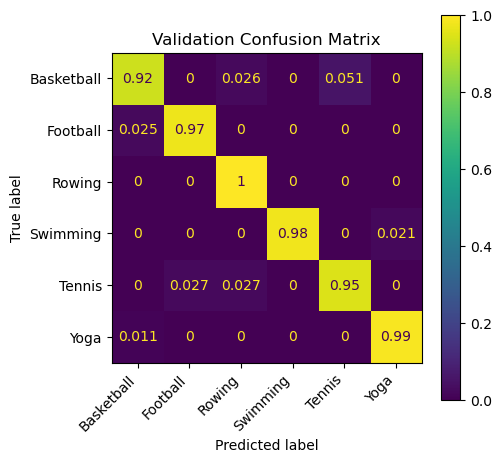

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

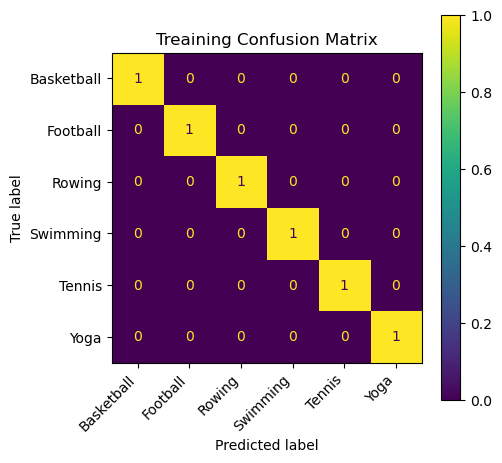

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_labels = np.zeros((len(train)))
all_pred = np.zeros((len(train)))

for idx,(images, labels) in enumerate(train_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Treaining Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()      

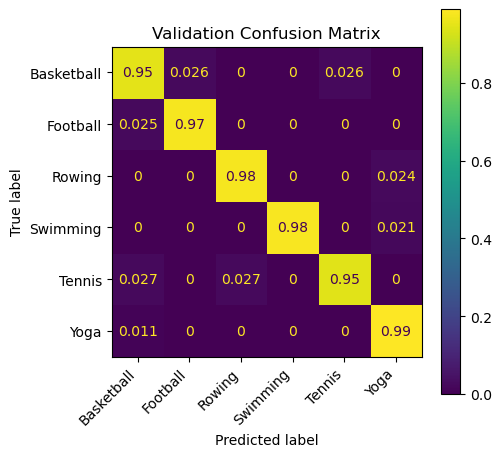

In [ ]:
model.load_state_dict(torch.load('best_model_xc.pt'))
model.eval()
all_labels = np.zeros((len(val)))
all_pred = np.zeros((len(val)))

for idx,(images, labels) in enumerate(valid_loader):
    bs= valid_loader.batch_size
    all_labels[idx*bs:(idx+1)*bs] = labels.cpu().numpy().flatten()
    with torch.no_grad():
        output = model(images.to(device) )
        _, pred = torch.max(output.data, 1)
        all_pred[idx*bs:(idx+1)*bs] = pred.cpu().numpy().flatten()
        
fig , ax= plt.subplots(figsize = (5,5))
cm = confusion_matrix(all_labels,all_pred,normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,
                             display_labels=list(val.class_to_idx.keys()) )
plt.title("Validation Confusion Matrix")
disp.plot(ax = ax)
plt.xticks(rotation=45, ha='right')
plt.show()  

# Testing:

In [ ]:
test = sport_dataset_test(test_dir, transform=tranform_test)
test_loader = DataLoader(test, batch_size=1,  shuffle=False ,num_workers=0)

pred_df  = pd.DataFrame(columns=['image_name','label'], index=range(len(test)))
with torch.no_grad():
    for idx, (images, name) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        predicted = outputs.max(1)[1].cpu().numpy()[0]
        pred_df.iloc[idx,:] =[name[0],predicted] 
        del images, outputs
pred_df.head(5)

,image_name,label
0,0.jpg,4
1,1.jpg,4
2,10.jpg,5
3,100.jpg,5
4,101.jpg,1


In [ ]:
pred_df.to_csv("xception_labels_last.csv", index= False)
torch.save(model.state_dict(), f"xception_model_val_score{max(val_acc):.4}.pt")